In [3]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2
import numpy as np
import pathlib
import matplotlib.pyplot as plt
from soilgasflux_fcs import json_reader, models
import xarray as xr



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
expected_ds = xr.open_dataset('./output/expected_synthetic_data62_2024-11-20.nc')
expected_ds

<xarray.Dataset> Size: 261kB
Dimensions:       (time: 1620, cutoff: 16)
Coordinates:
  * time          (time) datetime64[ns] 13kB 2024-11-20T00:11:27 ... 2024-11-...
  * cutoff        (cutoff) int32 64B 20 30 40 50 60 70 ... 130 140 150 160 170
Data variables:
    dcdt(HM)      (time, cutoff) float64 207kB ...
    deadband      (time) int64 13kB ...
    d_intensity   (time) int64 13kB ...
    d_startpoint  (time) int64 13kB ...
    add_noise     (time) bool 2kB ...

In [6]:
ds = xr.open_dataset('./output/synthetic_data62_2024-11-20.nc')
ds

<xarray.Dataset> Size: 7MB
Dimensions:       (time: 1620, cutoff: 16, deadband: 6)
Coordinates:
  * time          (time) datetime64[ns] 13kB 2024-11-20T00:11:27 ... 2024-11-...
  * deadband      (deadband) int32 24B 0 10 20 30 40 50
  * cutoff        (cutoff) int32 64B 20 30 40 50 60 70 ... 130 140 150 160 170
Data variables:
    dcdt(HM)      (time, cutoff, deadband) float64 1MB ...
    dcdt(linear)  (time, cutoff, deadband) float64 1MB ...
    AIC(HM)       (time, cutoff, deadband) float64 1MB ...
    AIC(linear)   (time, cutoff, deadband) float64 1MB ...
    RMSE(HM)      (time, cutoff, deadband) float64 1MB ...
    RMSE(linear)  (time, cutoff, deadband) float64 1MB ...

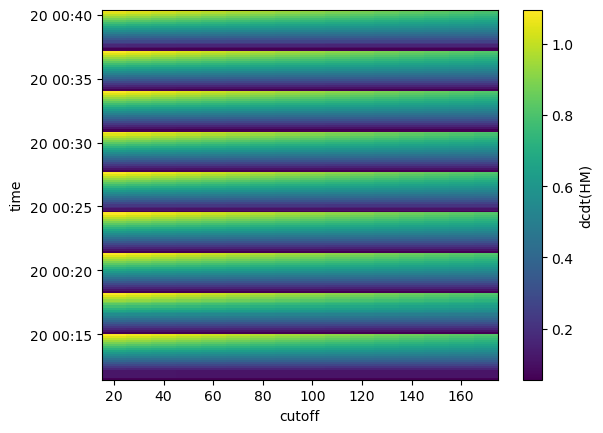

In [9]:
expected_ds['dcdt(HM)'].plot()